# 5. Topic Modeling

**Table of Contents:**
- Topic Modeling per community:
  - WordCloud
  - BERTopic
- Topic modeling per time window
- Topic modeling per subreddit

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from wordcloud import WordCloud
import praw
import pandas as pd
import json
from datetime import datetime
from nltk.corpus import stopwords
import nltk
from PIL import Image
from bertopic import BERTopic


# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])
df_comments = pd.read_csv('../data/comments_graph_ending_final.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
df_communities = pd.read_csv('../data/communities.csv')
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))
df_communities = pd.read_csv('../data/communities.csv')

## Topic Modeling per community

### World Cloud

In [2]:
node_to_comm = dict(zip(df_communities["node"], df_communities["infomap_community"]))
def get_community(row):
    parent_comm = node_to_comm.get(row["parent"])
    child_comm = node_to_comm.get(row["child"])
    if parent_comm is not None and child_comm is not None:
        if parent_comm == child_comm:
            return parent_comm
        else:
            return None # skeep inter-community edges
    elif parent_comm is not None:
        return parent_comm
    elif child_comm is not None:
        return child_comm
    else:
        return None

df_comments["community"] = df_comments.apply(get_community, axis=1)
df_comments_comm = df_comments[df_comments["community"].notna()].copy()
df_comments_comm["community"] = df_comments_comm["community"].astype(int)
community_texts = df_comments_comm.groupby("community")["text_comment"].apply(list).to_dict()
print(community_texts[0][:3])

["I know I'm late, but I was going to say this too....also, I think it's how they take in the fluid causes deformity.  Either by ingesting it, injecting in various parts of the body, etc...", '“Well, well, well, if it isn’t the consequences of my own actions.”', 'Yup , he was putting in that work against Eren but like Pieck told him he’s so agitated and impatient. Why do you dislike Porco ? Personally I don’t really dislike any of the warriors anymore but I have a better ‘connection’ with the people of Paradis Island so I’ll root for them.']


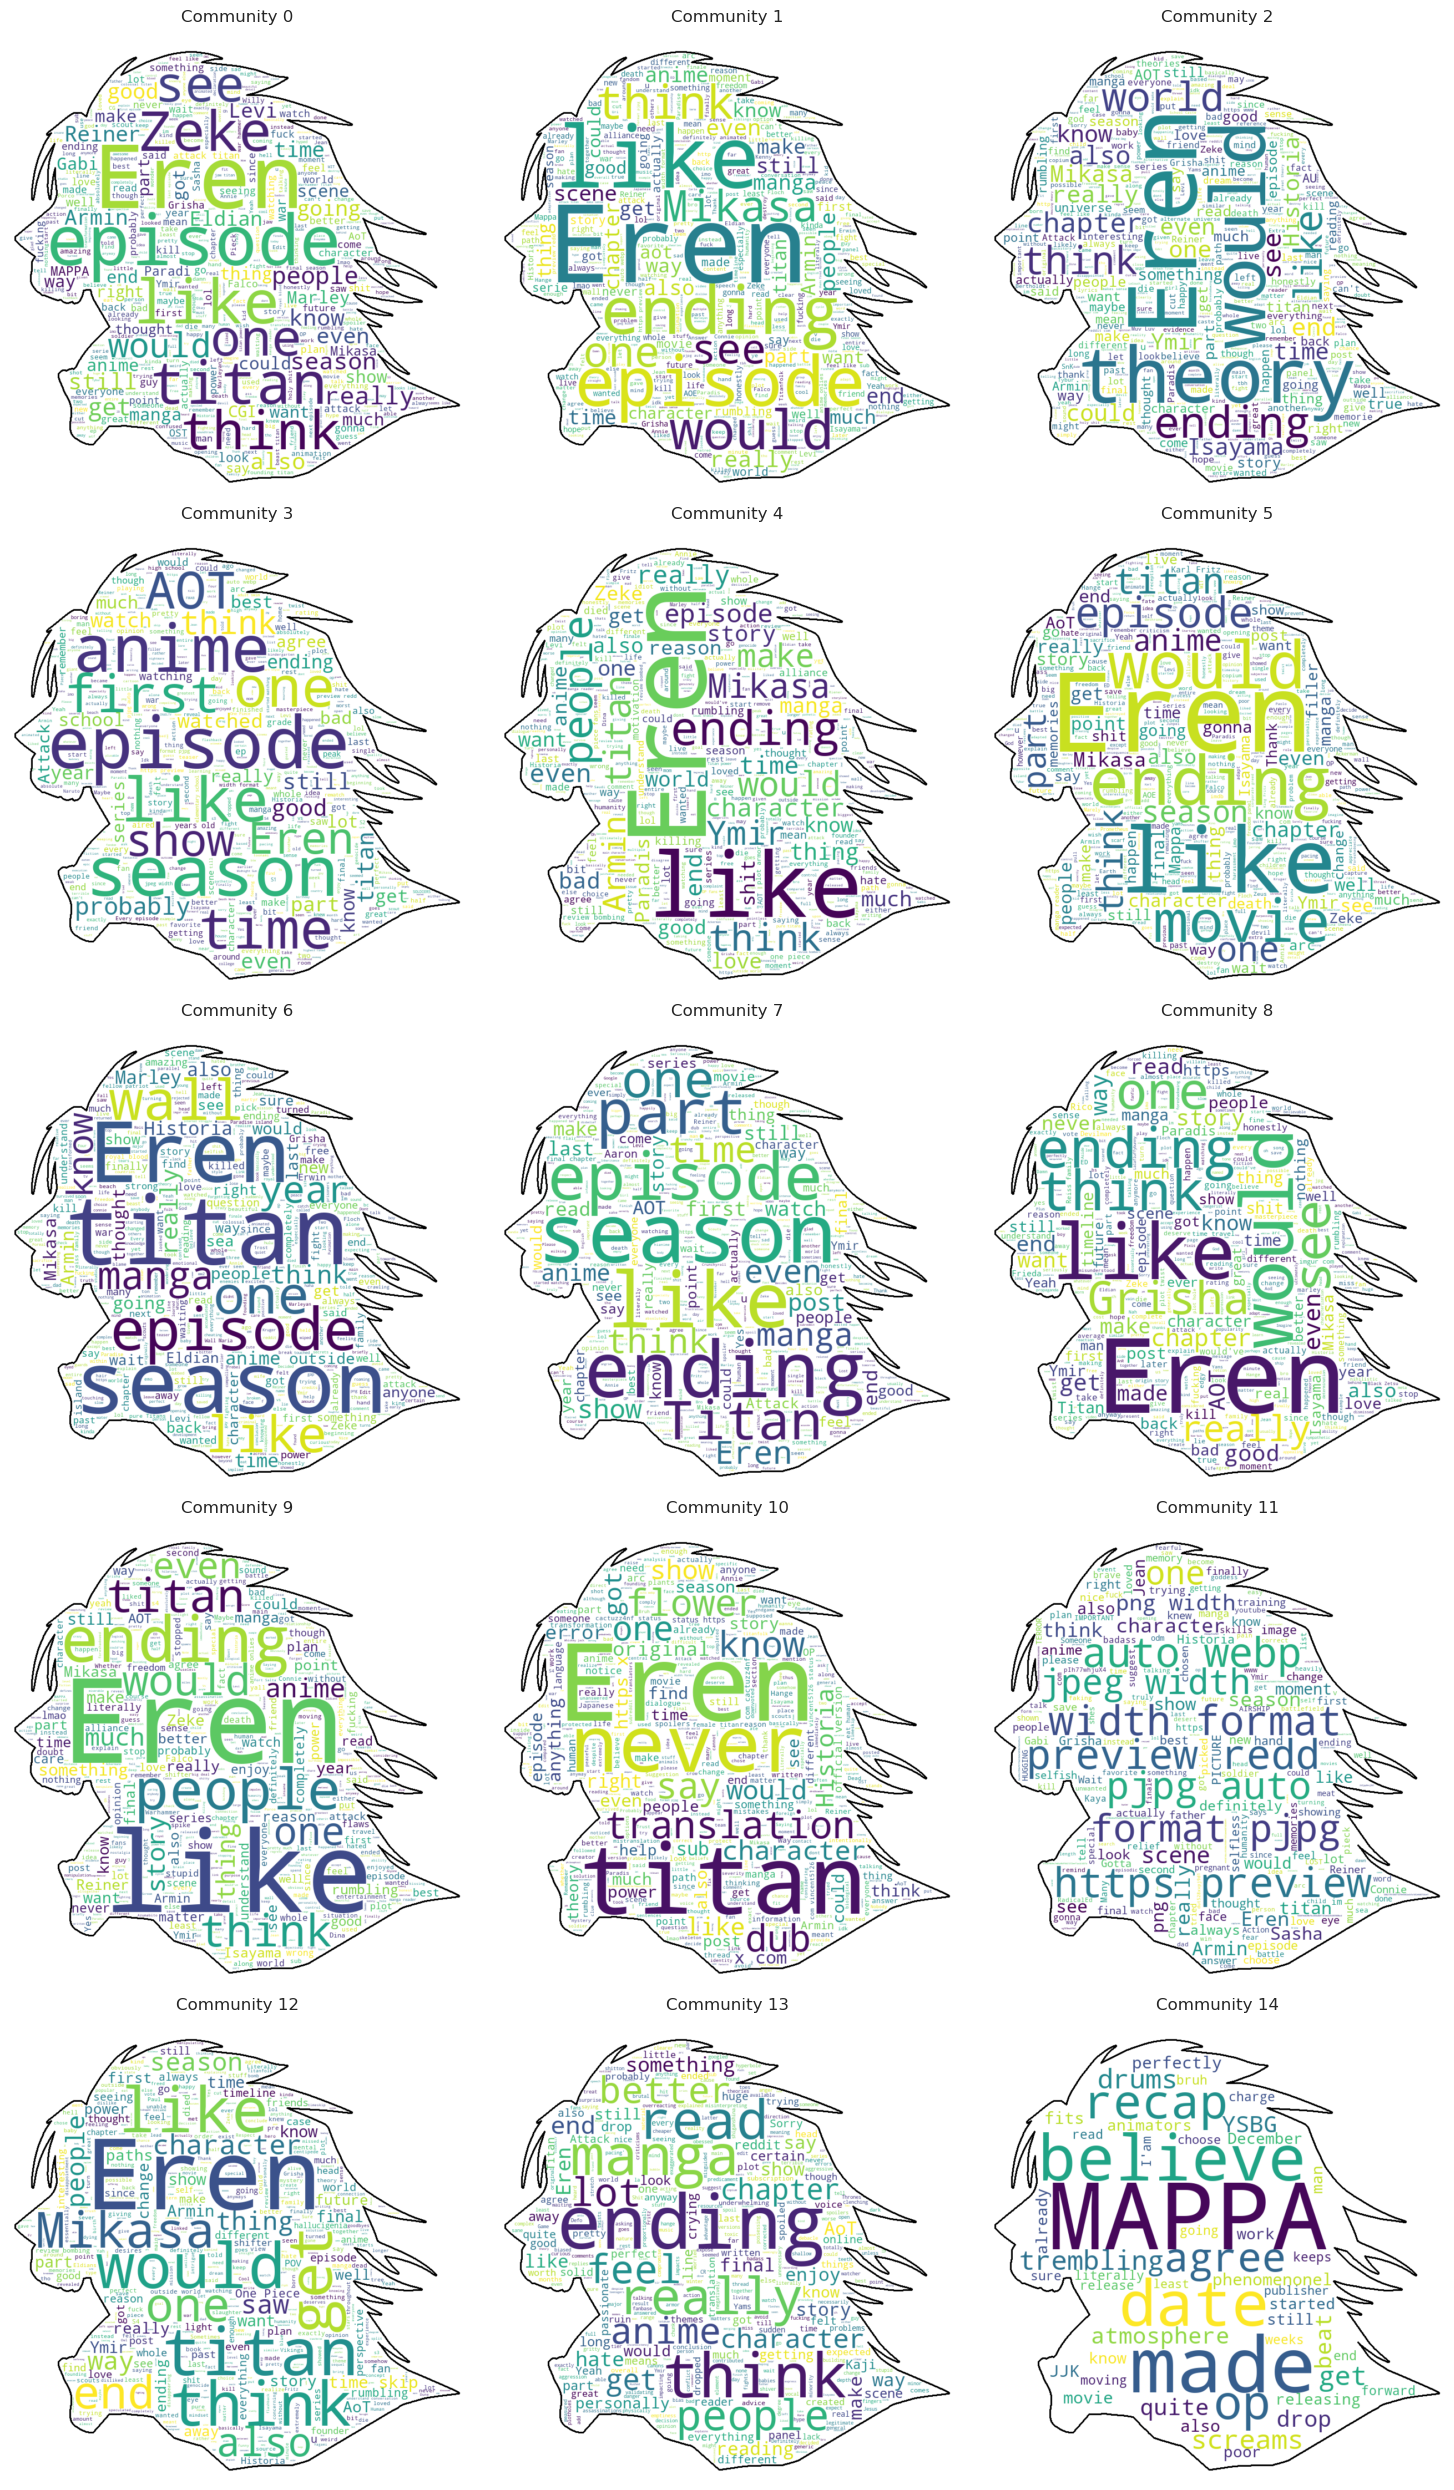

In [3]:
# mask
img = Image.open('../images/mask_erenTitanForm.jpeg')
eren_mask = np.array(img).mean(axis=2).astype(np.uint8)
threshold = 128  # You can adjust this value
eren_mask = np.where(eren_mask > threshold, 255, 0).astype(np.uint8)

# This time we can't remove the domain specific stopwords like the names of the characters.
# we are delving into the communities for trying to differentiate them.
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

# Create subplots with 3 columns per row
communities = list(community_texts.keys())
num_communities = len(communities)
rows = (num_communities + 2) // 3  # Calculate number of rows needed

fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else axes

for i, comm in enumerate(communities):
    texts = community_texts[comm]
    combined_text = " ".join(texts)
    wc = WordCloud(
        width=800, height=400, background_color="white", colormap='viridis',
        stopwords=STOPWORDS, max_words=500,
        mask=eren_mask, contour_width=2, contour_color='black'
    ).generate(combined_text)
    
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {comm}")

# Hide any unused subplots
for i in range(num_communities, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Eren is in the minds of all the communities (literally)

## BERTopic

[BERTopic](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html)


1. **BERT Embeddings**:  
BERTopic uses BERT, a language model, to create contextualized embeddings for each document in the corpus. These embeddings capture the semantic meaning of the text. 
1. **UMAP Dimensionality Reduction**:  
The high-dimensional BERT embeddings are reduced using UMAP, a dimensionality reduction technique. This simplifies the clustering process and makes the topics more interpretable. 
1. **HDBSCAN Clustering**:  
HDBSCAN, a density-based clustering algorithm, is used to group similar documents into topics. 
1. **c-TF-IDF for Topic Representation**:  
Class-based TF-IDF (c-TF-IDF) is used to generate descriptive phrases for each topic. It calculates the term frequency and inverse document frequency within each cluster, for highlighting the most important words for that topic. 

In [4]:
topic_models = {}
for comm, texts in community_texts.items():
    if len(texts) > 10:  # avoid too small sets
        topic_model = BERTopic(language="english")
        topics, probs = topic_model.fit_transform(texts)
        topic_models[comm] = topic_model


We can plot in the embedding spaces (actually the dimensionality reduction of them) the topics that are covered

In [5]:
comm = 0
topic_models[comm].visualize_topics()


`Topic = -1` refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [6]:
topic_models[0].get_topic_info()


Topic  Count                                     Name  \
0       -1   3448                         -1_the_to_and_of   
1        0    394                0_cgi_cg_animation_looked   
2        1    252            1_marley_paradis_eldians_they   
3        2    225                   2_mappa_mappas_cgi_wit   
4        3    188                     3_ymir_ymirs_her_she   
..     ...    ...                                      ...   
144    143     11                143_half_finale_us_abrupt   
145    144     11             144_leg_cutting_eye_hospital   
146    145     10     145_she_stomach_fought_sureotherwise   
147    146     10  146_reiners_welldone_audiances_splendid   
148    147     10           147_humans_terror_smile_theyre   

                                        Representation  \
0     [the, to, and, of, that, it, this, eren, is, in]   
1    [cgi, cg, animation, looked, good, but, scenes...   
2    [marley, paradis, eldians, they, their, them, ...   
3    [mappa, mappas, cgi, wit, animation, studio, f...   
4    [ymir, ymirs, her, she, slave, royal, power, f...   
..                                                 ...   
144  [half, finale, us, abrupt, season, last, endin...   
145  [leg, cutting, eye, hospital, off, his, coul, ...   
146  [she, stomach, fought, sureotherwise, lungabov...   
147  [reiners, welldone, audiances, splendid, trans...   
148  [humans, terror, smile, theyre, afraid, monste...   

                                   Representative_Docs  
0    [I feel like the anime-onlies' reaction to Ere...  
1    [What I've noticed this episode is that the CG...  
2    [Except that Eren didn't only attack Marley He...  
3    [I'll be honest, I might have like terrible ey...  
4    [Incredible episode but I'm still so confused....  
..                                                 ...  
144  [Did anyone else feel that the ending was way ...  
145  [Why was Eren in the trenches cutting his leg ...  
146  [Why did it have to be in her stomach of all p...  
147  [Just love how there are these devastating mom...  
148  [Love how the Titans fear humans now and see t...  

[149 rows x 5 columns]

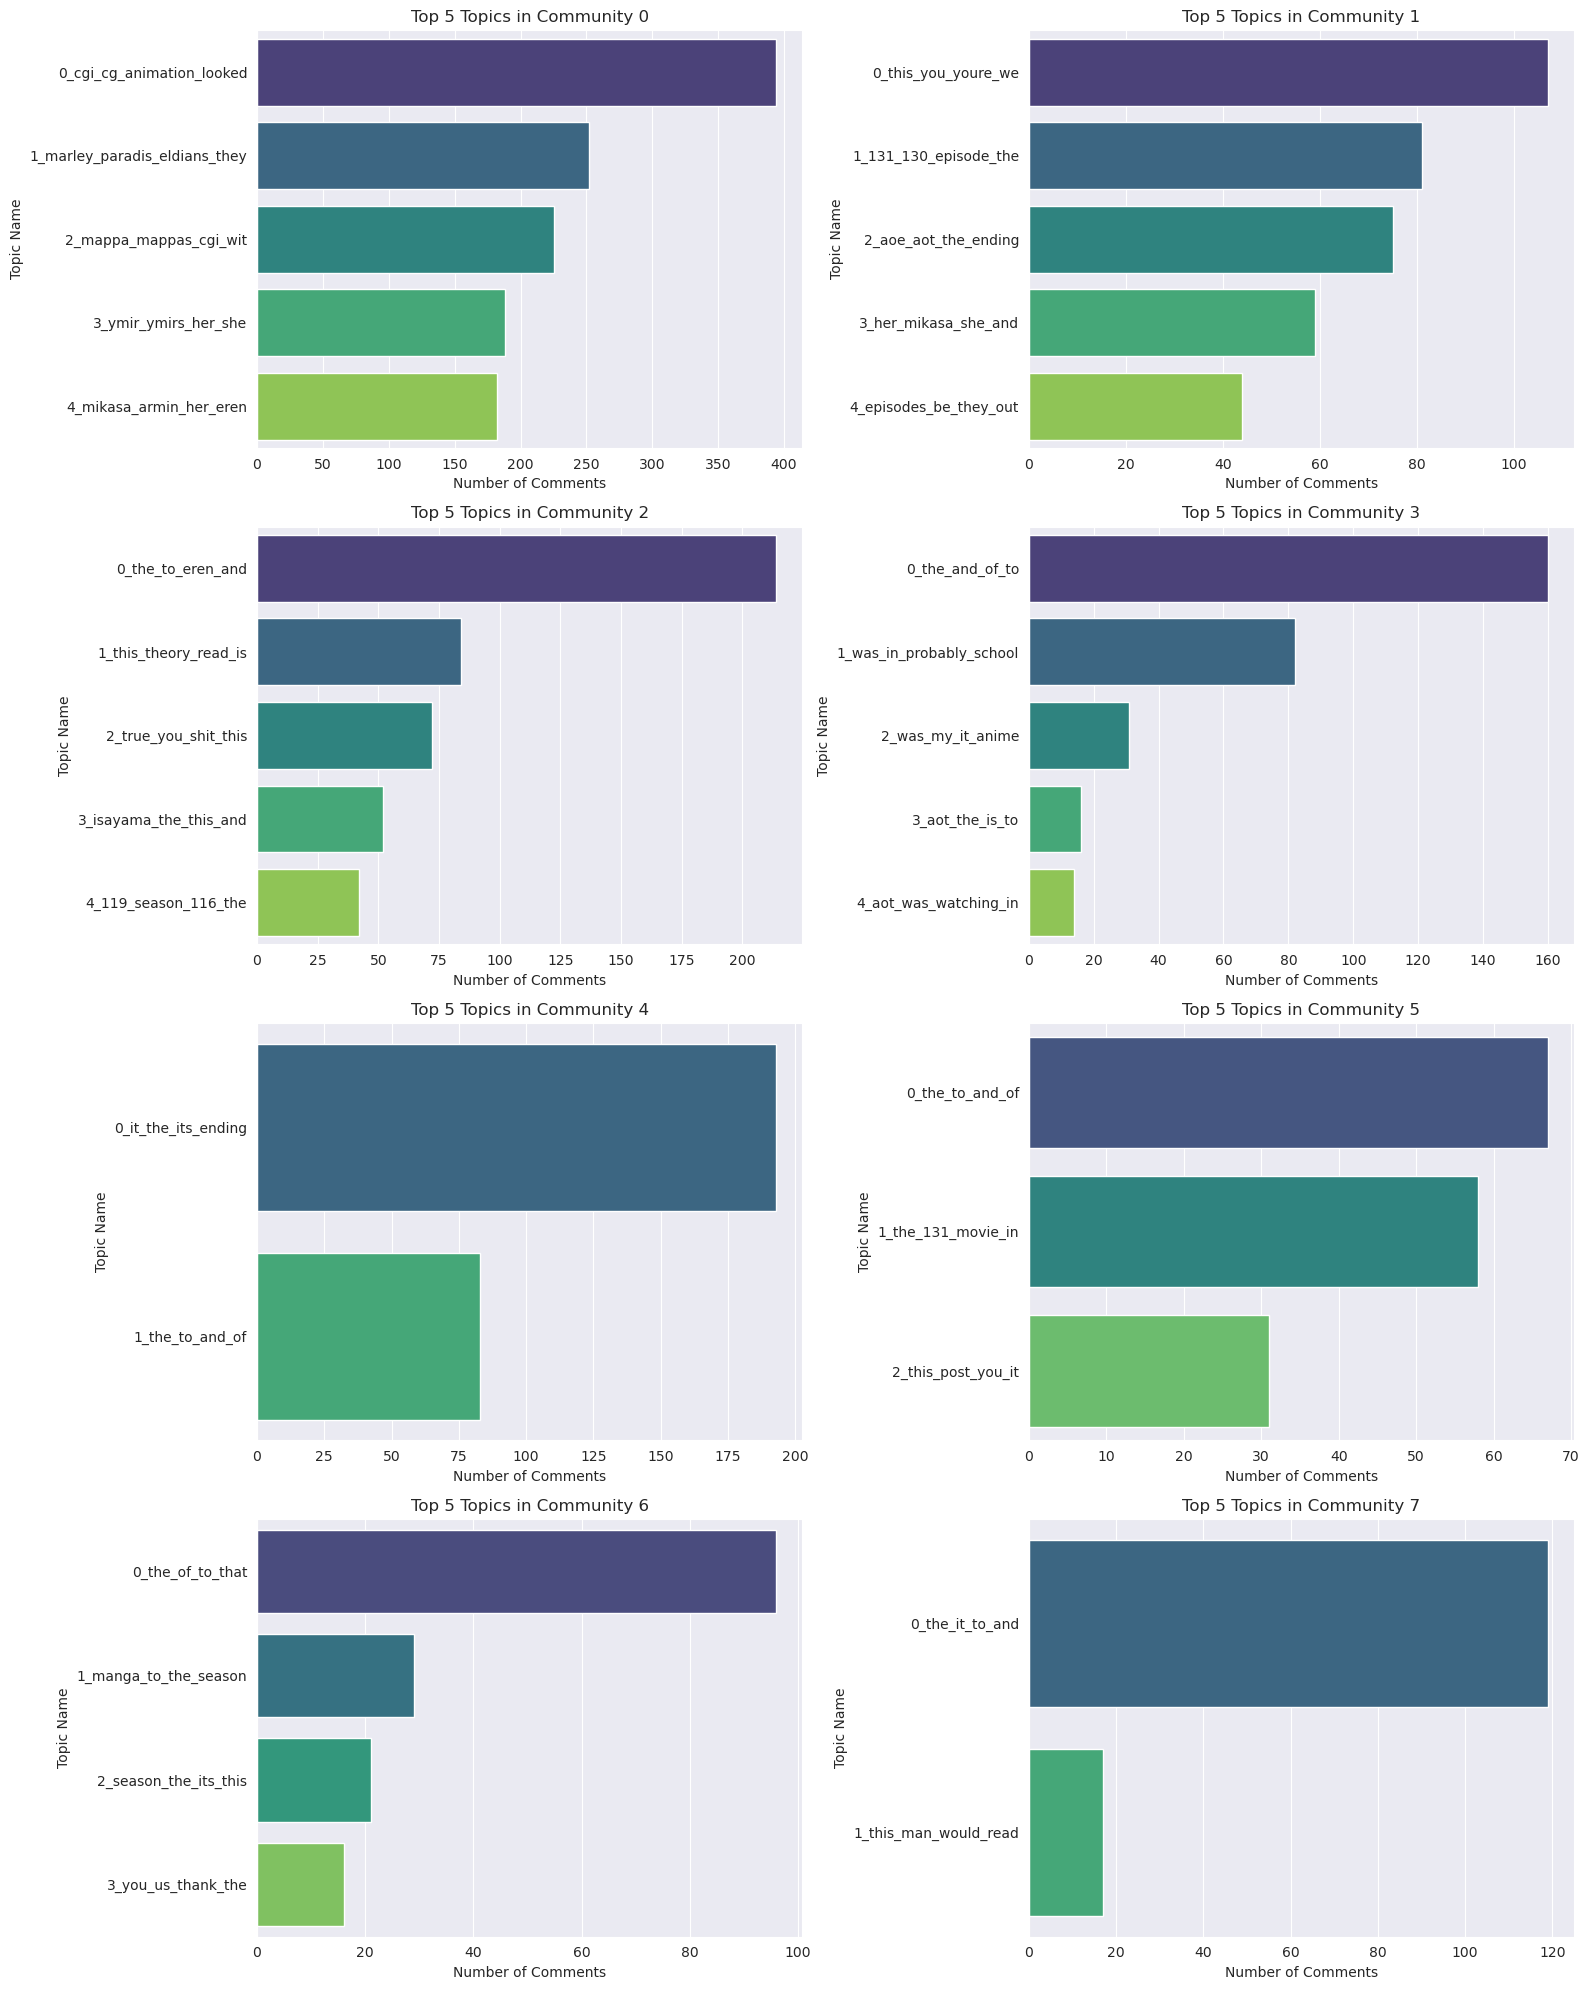

In [7]:
def plot_topic_counts(topic_df, community_id, top_n=5):
    # Skip outlier topic (-1) and get top topics
    df_plot = topic_df[topic_df['Topic'] != -1].sort_values(by='Count', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='Count', y='Name', palette='viridis')
    plt.title(f"Top {top_n} Topics in Community {community_id}")
    plt.xlabel("Number of Comments")
    plt.ylabel("Topic Name")
    plt.tight_layout()
    plt.show()

# Get top 8 communities by size
top_communities = sorted(topic_models.keys())[:8]

# Create subplots with 2 columns per row
rows = (len(top_communities) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 5*rows))
axes = axes.flatten()

for i, comm in enumerate(top_communities):
    topic_df = topic_models[comm].get_topic_info()
    df_plot = topic_df[topic_df['Topic'] != -1].sort_values(by='Count', ascending=False).head(5)
    
    if not df_plot.empty:
        sns.barplot(data=df_plot, x='Count', y='Name', palette='viridis', ax=axes[i])
        axes[i].set_title(f"Top 5 Topics in Community {comm}")
        axes[i].set_xlabel("Number of Comments")
        axes[i].set_ylabel("Topic Name")
    else:
        axes[i].text(0.5, 0.5, f"No topics found\nfor Community {comm}", 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f"Community {comm}")

# Hide any unused subplots
for i in range(len(top_communities), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


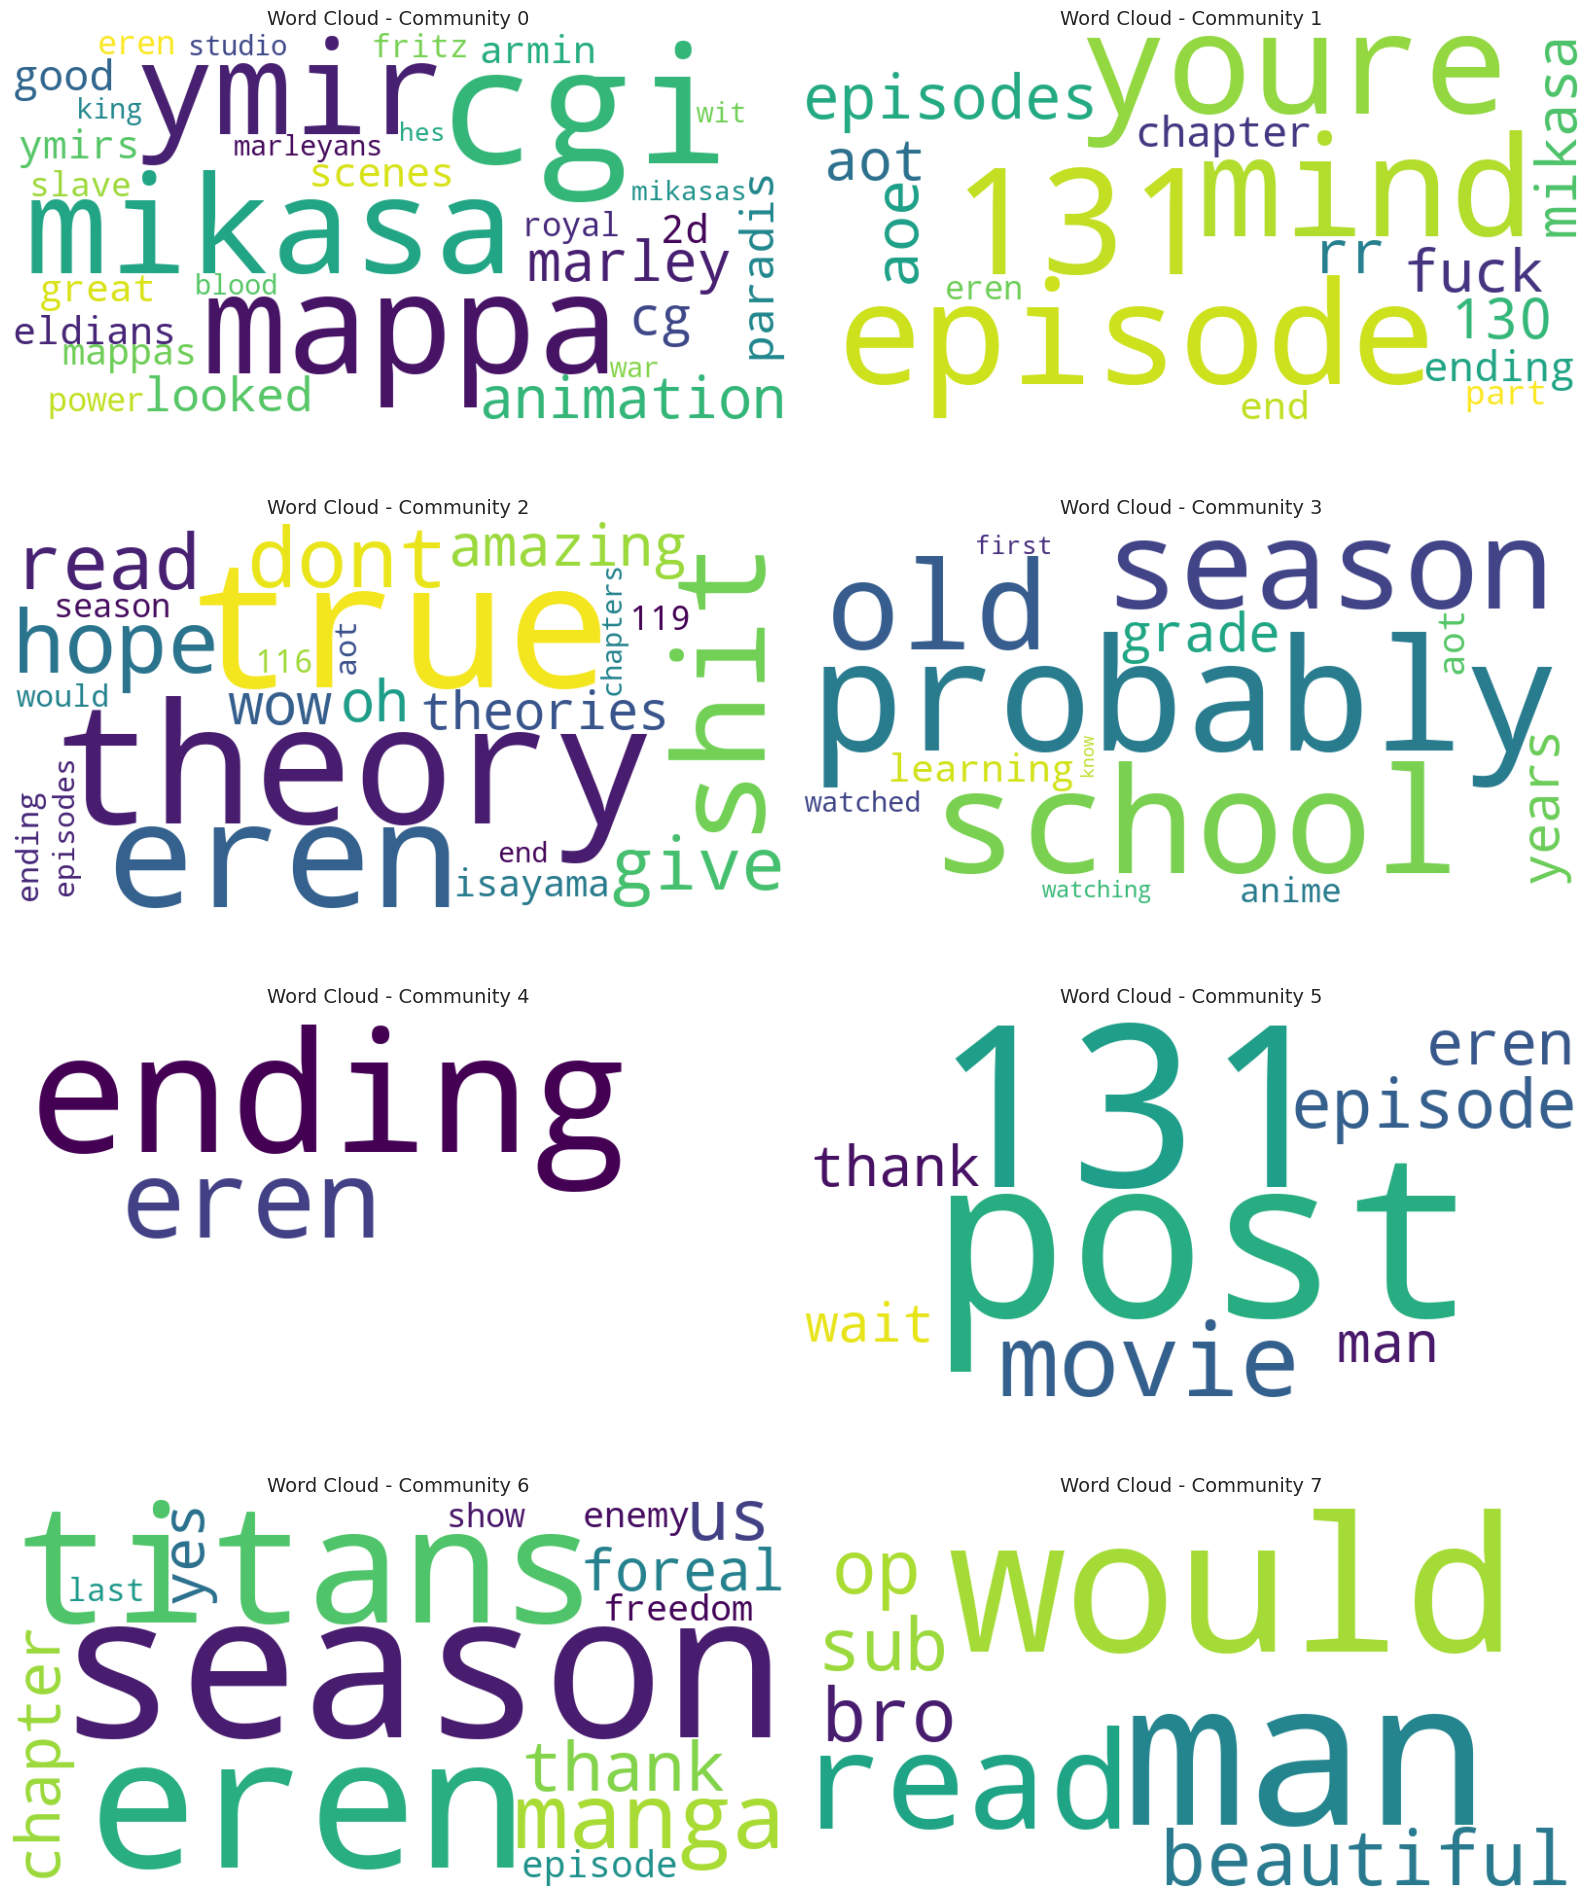

In [8]:
rows = (len(top_communities) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 5*rows))
axes = axes.flatten()

STOPWORDS = set(stopwords.words('english')).union({
    "like", "just", "really", "even", "one", "get", "thing", "things", "also"
})

# NUMBER OF TOPICS TO SHOW
top_n = 5

for i, comm in enumerate(top_communities):
    model = topic_models[comm]
    topic_info = model.get_topic_info()

    # Remove outlier topic -1
    topic_info = topic_info[topic_info["Topic"] != -1]
    if topic_info.empty:
        axes[i].text(0.5, 0.5, f"No topics for Community {comm}",
                     ha='center', va='center', fontsize=14)
        axes[i].axis('off')
        continue

    top_topics = topic_info.nlargest(top_n, 'Count')[["Topic", "Count"]]

    word_freq = {}
    for _, row in top_topics.iterrows():
        topic_id = row["Topic"]
        topic_count = row["Count"]
        for word, weight in model.get_topic(topic_id):
            word = word.lower()
            if word not in STOPWORDS:
                # Weight by topic size
                word_freq[word] = word_freq.get(word, 0) + (weight * topic_count)

    if not word_freq:
        axes[i].text(0.5, 0.5, f"No keywords left\nafter stopword removal",
                     ha='center', va='center', fontsize=12)
        axes[i].axis('off')
        continue

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - Community {comm}", fontsize=14)

# Hide any unused axes
for i in range(len(top_communities), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Topic modeling per time window

time periods:

1. start - mid_2020
2. mid_2020 - mid_2021
3. mid_2021 - mid_2022
4. mid_2022 - end

In [9]:
mid_2020 = pd.Timestamp("2020-06-30")
mid_2021 = pd.Timestamp("2021-06-30")
mid_2022 = pd.Timestamp("2022-06-30")

df_comments["created_dt"] = pd.to_datetime(df_comments["created_utc"], unit="s")

def assign_period(dt):
    if dt <= mid_2020:
        return "period_1 (until mid_2020)"
    elif dt <= mid_2021:
        return "period_2 (mid_2020 → mid_2021)"
    elif dt <= mid_2022:
        return "period_3 (mid_2021 → mid_2022)"
    else:
        return "period_4 (mid_2022 → end)"

df_comments["custom_period"] = df_comments["created_dt"].apply(assign_period)


In [10]:
period_topic_results = {}

for period, group in df_comments.groupby("custom_period"):
    texts = group["text_comment"].dropna().tolist()

    if len(texts) < 10:
        print(f"Skipping {period}, not enough data ({len(texts)} comments)")
        continue

    print(f"\nRunning BERTopic for: {period} ({len(texts)} comments)")

    topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=False)
    topics, probs = topic_model.fit_transform(texts)

    topic_info = topic_model.get_topic_info()
    topic_info["Representative_Docs"] = [
        topic_model.get_representative_docs(i) for i in topic_info.Topic
    ]

    period_topic_results[period] = {
        "model": topic_model,
        "info": topic_info,
        "texts": texts,
        "topics": topics,
    }



Running BERTopic for: period_1 (until mid_2020) (286 comments)

Running BERTopic for: period_2 (mid_2020 → mid_2021) (8696 comments)

Running BERTopic for: period_3 (mid_2021 → mid_2022) (3021 comments)

Running BERTopic for: period_4 (mid_2022 → end) (2001 comments)


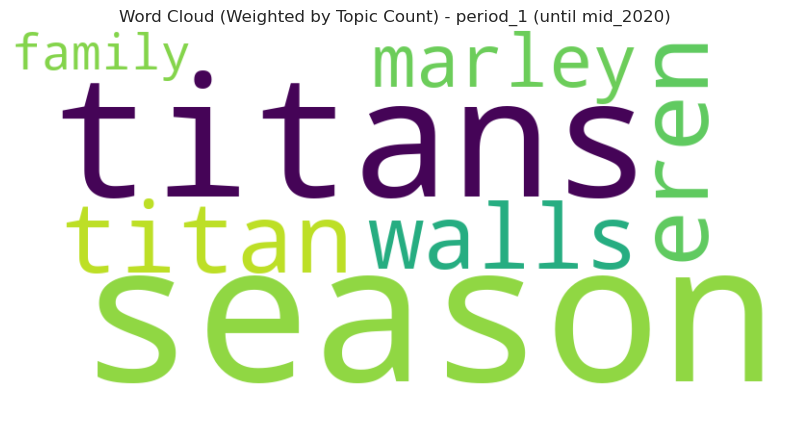

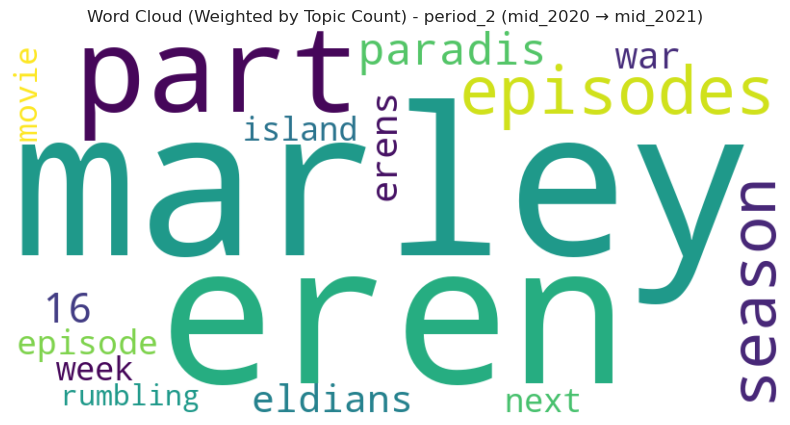

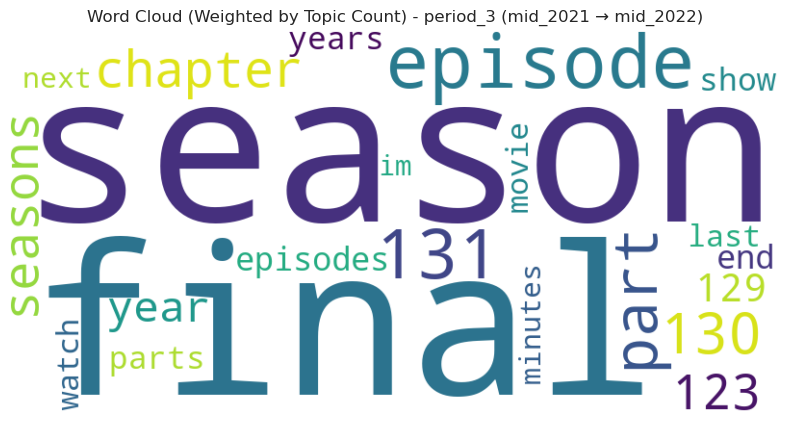

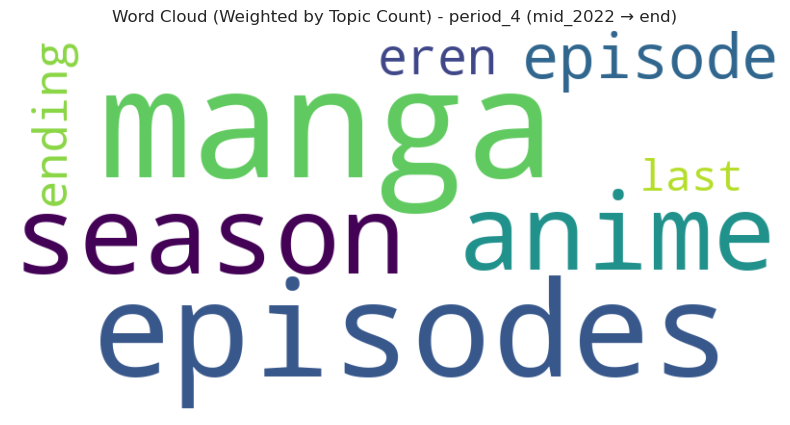

In [11]:
STOPWORDS = set(stopwords.words('english')).union({
    "like", "just", "really", "even", "one", "get", "thing", "things", "also"
})
# NUMBER OF TOPICS TO SHOW
top_n = 3 

for period, data in period_topic_results.items():
    topic_model = data["model"]
    topic_info = topic_model.get_topic_info()

    # Remove outlier topic -1
    topic_info = topic_info[topic_info["Topic"] != -1]
    if topic_info.empty:
        print(f"No valid topics for {period}")
        continue

    top_topics = topic_info.nlargest(top_n, 'Count')[["Topic", "Count"]]

    # Aggregate keywords across top N topics, weighted by topic Count
    word_freq = {}
    for _, row in top_topics.iterrows():
        topic_id = row["Topic"]
        topic_count = row["Count"]
        for word, weight in topic_model.get_topic(topic_id):
            word = word.lower()
            if word not in STOPWORDS:
                # Multiply weight by topic size (Count)
                word_freq[word] = word_freq.get(word, 0) + (weight * topic_count)

    if not word_freq:
        print(f"No keywords left for {period} after stopword removal")
        continue

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud (Weighted by Topic Count) - {period}")
    plt.show()


As we expect from the story of the manga we have:
1. start - mid_2020: eren and titans
2. mid_2020 - mid_2021: war between marley and paradis
3. mid_2021 - mid_2022: finale... shit, hope, fuck, bruh, lmfao
4. mid_2022 - end: just the end

## Topic modeling per subreddit

Subreddit comment counts:
AttackOnRetards: 1037 comments
attackontitan: 8129 comments
titanfolk: 4838 comments

Running BERTopic for subreddit: AttackOnRetards (1037 comments)

Running BERTopic for subreddit: attackontitan (8129 comments)

Running BERTopic for subreddit: titanfolk (4838 comments)


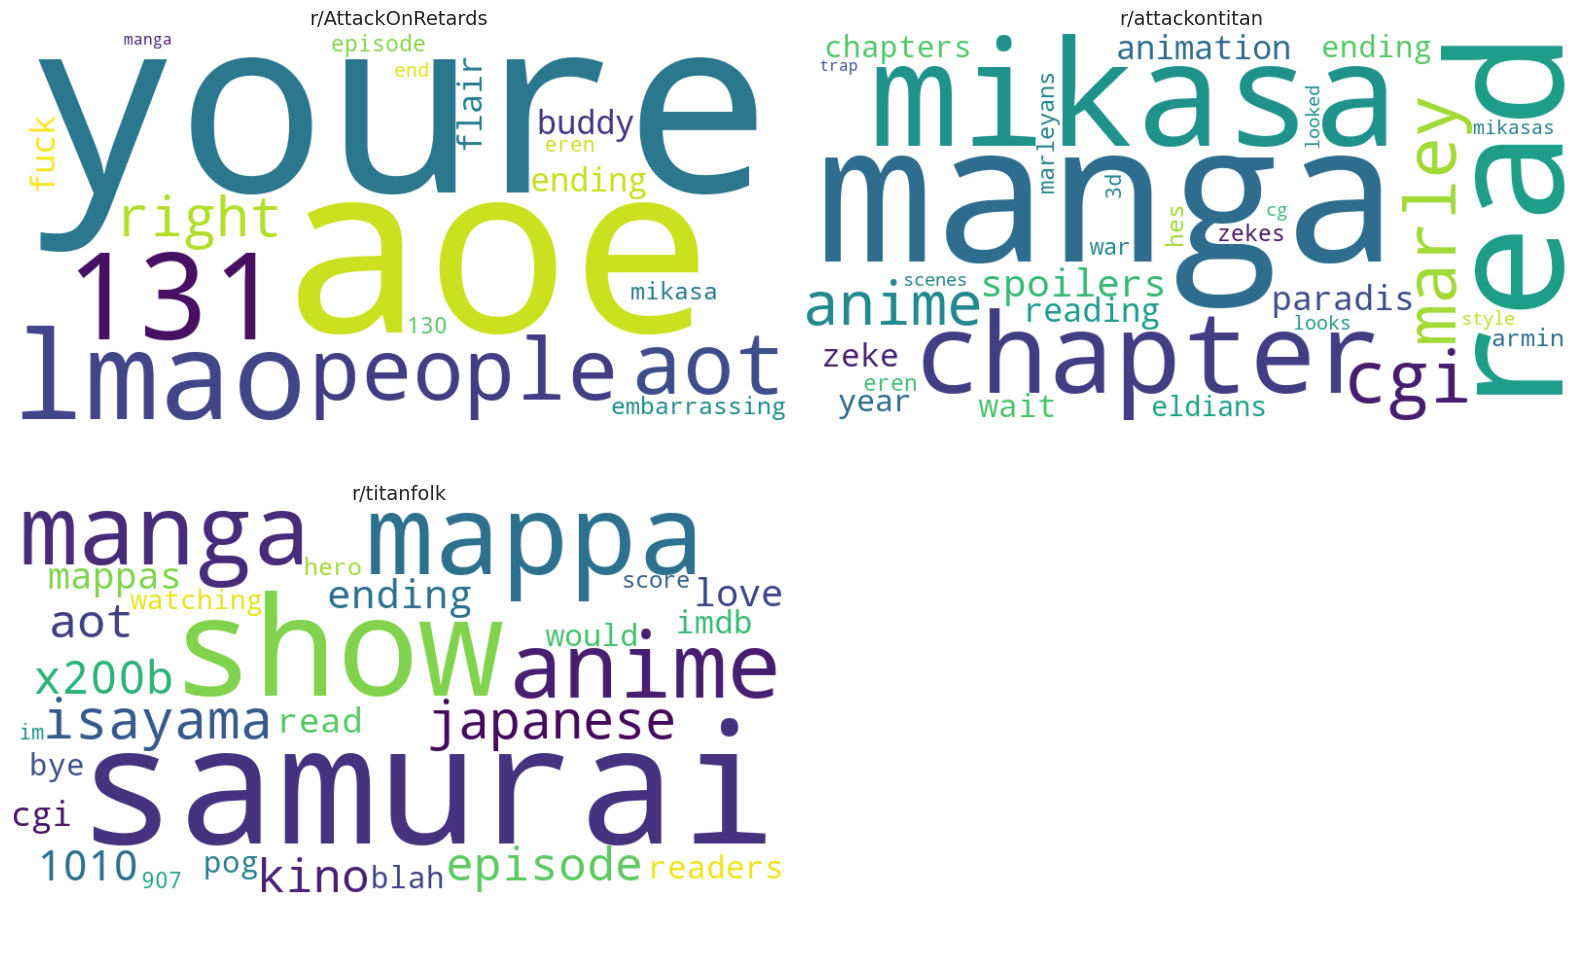


TOPIC SUMMARIES BY SUBREDDIT

r/AttackOnRetards:
----------------------------------------
Topic 0 (104 comments): 0_aoe_aot_to_the
Topic 1 (71 comments): 1_this_you_youre_lmao
Topic 2 (65 comments): 2_her_mikasa_she_the
Topic 3 (63 comments): 3_131_episode_130_of
Topic 4 (42 comments): 4_ending_the_will_is

r/attackontitan:
----------------------------------------
Topic 0 (383 comments): 0_manga_read_chapter_anime
Topic 1 (271 comments): 1_marley_paradis_eldians_they
Topic 2 (167 comments): 2_mikasa_armin_her_eren
Topic 3 (122 comments): 3_zeke_zekes_he_his
Topic 4 (118 comments): 4_cgi_animation_3d_looks

r/titanfolk:
----------------------------------------
Topic 0 (215 comments): 0_mappa_mappas_and_the
Topic 1 (183 comments): 1_isayama_aot_ending_that
Topic 2 (162 comments): 2_manga_anime_read_readers
Topic 3 (81 comments): 3_samurai_show_japanese_x200b
Topic 4 (80 comments): 4_episode_1010_imdb_blah


In [14]:
# group comments by subreddit
subreddit_texts = df_comments.groupby("subreddit")["text_comment"].apply(list).to_dict()
print("Subreddit comment counts:")
for subreddit, texts in subreddit_texts.items():
    print(f"{subreddit}: {len(texts)} comments")

# Run BERTopic for each subreddit (minimum 50 comments for meaningful analysis)
subreddit_topic_models = {}
min_comments = 50

for subreddit, texts in subreddit_texts.items():
    if len(texts) >= min_comments:
        print(f"\nRunning BERTopic for subreddit: {subreddit} ({len(texts)} comments)")
        topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=False)
        topics, probs = topic_model.fit_transform(texts)
        subreddit_topic_models[subreddit] = topic_model
    else:
        print(f"Skipping {subreddit}: only {len(texts)} comments (minimum {min_comments} required)")

# Generate word clouds for each subreddit's top topics
STOPWORDS = set(stopwords.words('english')).union({
    "like", "just", "really", "even", "one", "get", "thing", "things", "also"
})
# NUMBER OF TOPICS TO SHOW
top_n = 5

subreddits_to_plot = list(subreddit_topic_models.keys())
num_subreddits = len(subreddits_to_plot)


cols = 2
rows = (num_subreddits + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 5*rows))
if rows == 1 and cols == 1:
    axes = [axes]
elif rows == 1 or cols == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()

for i, subreddit in enumerate(subreddits_to_plot):
    topic_model = subreddit_topic_models[subreddit]
    topic_info = topic_model.get_topic_info()

    # Remove outlier topic -1
    topic_info = topic_info[topic_info["Topic"] != -1]
    
    if topic_info.empty:
        axes[i].text(0.5, 0.5, f"No valid topics\nfor r/{subreddit}",
                    ha='center', va='center', fontsize=12)
        axes[i].axis('off')
        axes[i].set_title(f"r/{subreddit}", fontsize=14)
        continue

    # get top topics weighted by count
    top_topics = topic_info.nlargest(top_n, 'Count')[["Topic", "Count"]]

    # aggregate keywords across top topics, weighted by topic count
    word_freq = {}
    for _, row in top_topics.iterrows():
        topic_id = row["Topic"]
        topic_count = row["Count"]
        for word, weight in topic_model.get_topic(topic_id):
            word = word.lower()
            if word not in STOPWORDS:
                word_freq[word] = word_freq.get(word, 0) + (weight * topic_count)

    if not word_freq:
        axes[i].text(0.5, 0.5, f"No keywords left\nafter stopword removal",
                    ha='center', va='center', fontsize=12)
        axes[i].axis('off')
        axes[i].set_title(f"r/{subreddit}", fontsize=14)
        continue

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"r/{subreddit}", fontsize=14)

for i in range(num_subreddits, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# topic summaries
print("\n" + "="*60)
print("TOPIC SUMMARIES BY SUBREDDIT")
print("="*60)

for subreddit in subreddits_to_plot:
    print(f"\nr/{subreddit}:")
    print("-" * 40)
    topic_info = subreddit_topic_models[subreddit].get_topic_info()
    valid_topics = topic_info[topic_info["Topic"] != -1].head(5)
    
    if not valid_topics.empty:
        for _, row in valid_topics.iterrows():
            topic_id = row["Topic"]
            count = row["Count"]
            name = row["Name"]
            print(f"Topic {topic_id} ({count} comments): {name}")
    else:
        print("No valid topics found")
